# Constrained Optimization: Equality and Inequality Constraints
###### Ilaria Curzi, Georgia Zavou
In this report, we describe how we implemented a Support Vector Machine (SVM) to solve a binary classification problem.
The goal of SVM is to find the hyperplane that best separates the two classes of data points. This hyperplane is the decision boundary that helps classify new data points. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(r"C:\Users\ilari\OneDrive\Desktop\MASTER UB\OPTIMIZATION\Practical5 (2)\compiled_code\compiled_code\Python3.8")

from QPGC import QPGenericConstraints

The first step in this process is the generation of the two datasets that will be used for training our model. We define a function that defines two classes, each with its own mean and covariance.

In [3]:
#n is the number of samples we want to generate for each class
#separable is a boolean flag that determines whether the dataset should be separable or non-separable

def generateDataset(n, separable=True):
    m1 = np.array([0., 0.])
    s1 = np.array([[1., -0.9], [-0.9, 1.]])

    if separable:
        m2 = np.array([3., 6.])
        s2 = np.array([[1., 0.], [0., 1.]])
    else:
        m2 = np.array([1., 2.])
        s2 = np.array([[1., 0.], [0., 1.]])

    pos_samples = np.random.multivariate_normal(m1, s1, n)
    neg_samples = np.random.multivariate_normal(m2, s2, n)

    x = np.concatenate((pos_samples, neg_samples)).T
    y = np.concatenate((np.ones(n), -1*np.ones(n)))

    return x,y

To solve this problem, we need to express it in matrix form because it's a quadratic programming problem, which is a type of optimization problem that can be solved using specialized methods. Thefore, we define the necessary matrices such as A, b, C, d, Y, and G, which define the constraints and the relationships between the data points. 

In [4]:
def generateMatrices(x, y, K):
    n = x.shape[1] 
    p = 1 
    m = 2*n 
    N = n + p + 2*m 

    # Initial vector/matrix variables
    A = y.reshape(n, p)
    b = np.zeros(p) 
    
    C = np.concatenate((np.eye(n), -np.eye(n)), axis = 1) 
    d = np.concatenate((np.zeros(n), -K*np.ones(n))) 
    
    Y = np.diag(y) 
    G = np.dot(np.dot(Y, x.T), np.dot(x, Y)) 
    g = -np.ones(n)

    return A, b, C, d, G, g

Next, we compute the weight vector w ,that defines the direction of the hyperplane, and the bias term b, that helps in positioning it. To do this, we use QPGenericConstraints, which returns a set of alpha values indicating the importance of each data point in defining the optimal hyperplane.

In [5]:
def compute_hyperplane(alpha, X, y):
    # Choosing that "best" point 
    min_dist = np.inf
    best_pair = None
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            if y[i] * y[j] < 0:
                dist = np.linalg.norm(X.T[i,:] - X.T[j,:])
                if dist < min_dist:
                    min_dist = dist
                    best_pair = (i, j)

    # Compute w
    w = np.sum(alpha * y * X, axis=1)

    # Compute b
    b = y[best_pair[0]] - np.dot(w.T, X.T[best_pair[0],:])

    return w, b

### First Experiment: Separable Dataset with 2 Points per Class


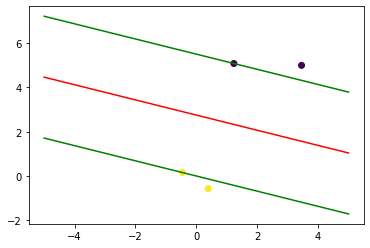

In [6]:
#  dataset
X, y = generateDataset(2)

# matrices
A, b, C, d, G, g = generateMatrices(X, y, 1)

# alpha 
alpha = QPGenericConstraints(G, g, A, C, b, d)

# hyperplane
w, b = compute_hyperplane(alpha, X, y)

# Plot 
linespace = np.linspace(-5, 5, 100)

plt.scatter(X[0,:], X[1,:], c=y)
plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
plt.show()

After computing the hyperplane, we plot the results. The hyperplane successfully separates the two classes, with the margin lines touching the support vectors. 

### Second Experiment: Separable Dataset with 100 Points per Class

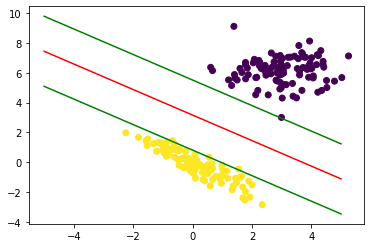

In [7]:
# Generate dataset
X, y = generateDataset(100)

# Generate matrices
A, b, C, d, G, g = generateMatrices(X, y, 1)

# Compute alpha 
alpha = QPGenericConstraints(G, g, A, C, b, d)

# Compute hyperplane
w, b = compute_hyperplane(alpha, X, y)

# Plot points, margins and hyperplane
linespace = np.linspace(-5, 5, 100)

plt.scatter(X[0,:], X[1,:], c=y)
plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
plt.show()

We observe that the model works well also in this case, perfectly separating the two classes while maximizing the margin.

### Experiment 3: Testing Stability Across Different Values of K

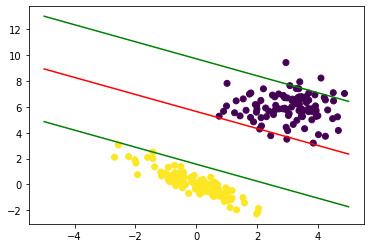

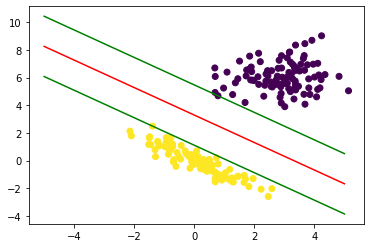

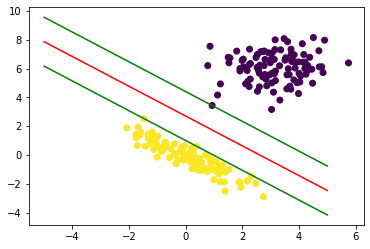

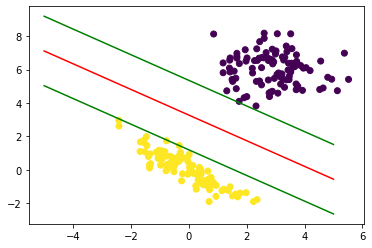

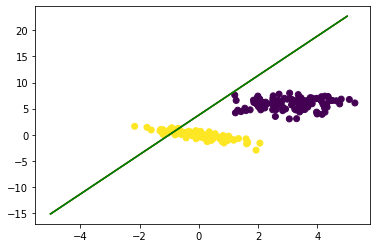

In [10]:
for K in [1e-3, 1, 1e3, 1e6, 1e12]:
    # Generate dataset
    X, y = generateDataset(100)

    # matrices
    A, b, C, d, G, g = generateMatrices(X, y, K)

    # alpha 
    alpha = QPGenericConstraints(G, g, A, C, b, d)

    # hyperplane
    w, b = compute_hyperplane(alpha, X, y)

    # Plot 
    linespace = np.linspace(-5, 5, 100)

    plt.scatter(X[0,:], X[1,:], c=y)
    plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
    plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
    plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
    plt.show()

In this case, we tasted the stability of the algorithm for different values of K: the larger the value of the parameter K, the larger the penalty for violating the separation. We observe that for very small values of K, like K=1e-3, the method doesn’t work well. This happens because the algorithm gives too much importance to minimizing errors and not enough to maximizing the margin, which leads to poor performance. On the other hand, for very large values of K, like K=1e12, the algorithm also fails. At this point,the penalty for misclassification becomes excessively large, leading to issues with convergence.
For more moderate values of K the hyperplane is properly placed, and the margin between the classes is clear and well-defined.

### Experiment 4: Non-Separable Case with Different Values of K

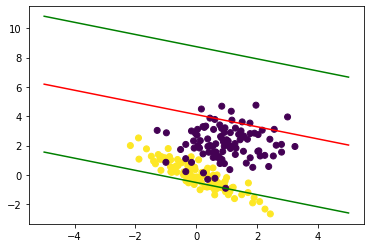

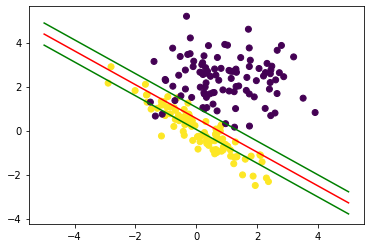

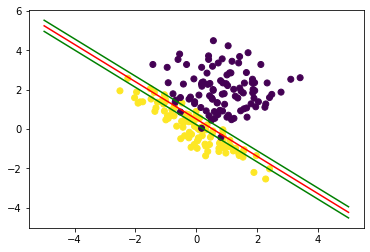

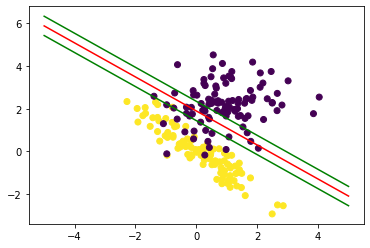

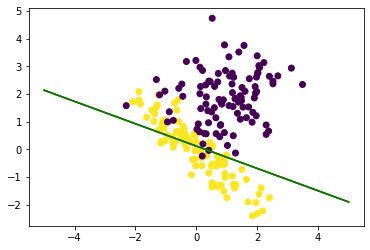

In [12]:
for K in [1e-3, 1, 1e3, 1e6, 1e12]:
    # dataset
    X, y = generateDataset(100, separable=False)

    # matrices
    A, b, C, d, G, g = generateMatrices(X, y, K)

    # alpha 
    alpha = QPGenericConstraints(G, g, A, C, b, d)

    # hyperplane
    w, b = compute_hyperplane(alpha, X, y)

    # Plot 
    linespace = np.linspace(-5, 5, 100)

    plt.scatter(X[0,:], X[1,:], c=y)
    plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
    plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
    plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
    plt.show()

In this experiment, we tested the algorithm on a non-separable dataset. 
When K is very small, the algorithm performs poorly since many of the samples fall within the margin regions. As K increases, the placement of the hyperplane gets better, balancing the trade-off between classification errors and the margin. However, when K becomes too large, the algorithm becomes unstable again.

To handle non-separable datasets more effectively, another approach is to use the kernel trick with SVM. This technique projects the data into a higher-dimensional space, where the classes might become linearly separable.